In [1]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 7.9 MB/s eta 0:00:00


## Import Library

In [2]:
import tensorflow as tf
import pandas as pd
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [3]:
from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow")

Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


## Problem properties

### Parametre: L'air

In [4]:
#l'air
rho= 1.2
mu=  1.8*10**-5
D= 0.5
L= 2.5
u_in=0.5*10**-1
c_p=1005
l=0.0257
t_in=300
t_BC=400


rho1=rho
mu1=mu
c_p1=c_p
l1=l


u1=u_in
L1=2*D
T1=t_BC
T0=t_in
Re=2000/3
#Re=(rho1*u1*L1)/mu1
Pr= (mu*c_p)/l
print(Re)

666.6666666666666


## Define loss function

In [5]:
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
    return on_wall

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

In [6]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i = 0, j = 0)
    du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
    dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
    dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)
    dp_x = dde.grad.jacobian(Y, X, i = 2, j = 0)
    dp_y = dde.grad.jacobian(Y, X, i = 2, j = 1)
    dt_x = dde.grad.jacobian(Y, X, i = 3, j = 0)
    dt_y = dde.grad.jacobian(Y, X, i = 3, j = 1)
    du_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 0)
    du_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 0)
    dv_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 1)
    dv_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 1)
    dt_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 3)
    dt_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 3)

    pde_u = Y[:,0:1]*du_x + Y[:,1:2]*du_y + dp_x - (1/Re)*(du_xx + du_yy)
    pde_v = Y[:,0:1]*dv_x + Y[:,1:2]*dv_y + dp_y - (1/Re)*(dv_xx + dv_yy)
    pde_t = Y[:,0:1]*dt_x+Y[:,1:2]*dt_y - (dt_xx+dt_yy)/(Re*Pr)

    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_t, pde_cont]

In [7]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 1)
bc_wall_t = dde.DirichletBC(geom, lambda X: 1., boundary_wall, component = 3)

bc_inlet_u = dde.DirichletBC(geom, lambda X: 1., boundary_inlet, component = 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component = 1)
bc_inlet_t = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component = 3)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 1)

## Generer des points pour entrainer

In [8]:
#create data to calcul
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u, bc_wall_v, bc_wall_t, bc_inlet_u, bc_inlet_v, bc_inlet_t, bc_outlet_p, bc_outlet_v],
                    num_domain = 1000,
                    num_boundary = 500)


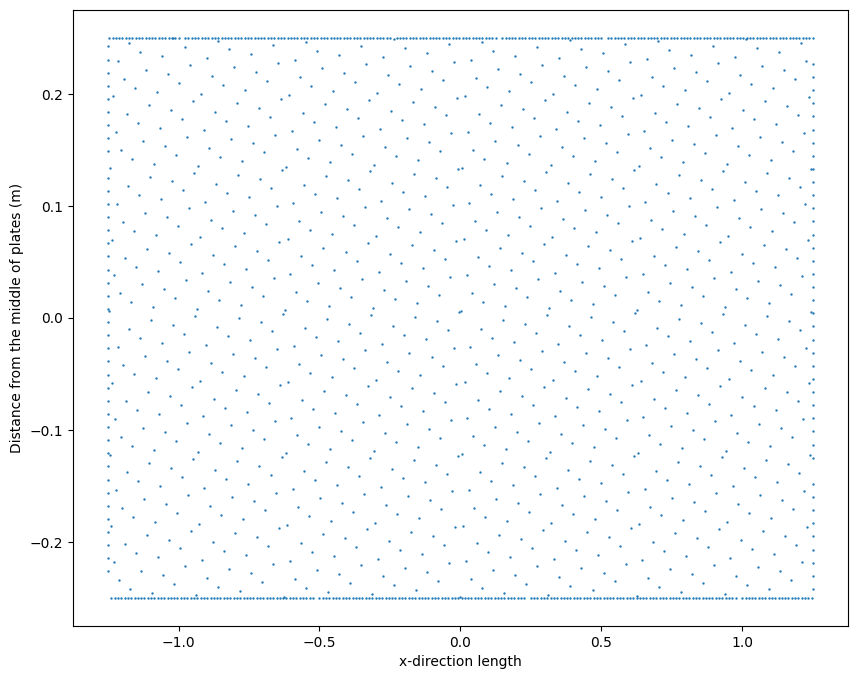

In [9]:
plt.figure(figsize = (10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.xlabel('x-direction length')
plt.ylabel('Distance from the middle of plates (m)')
plt.show()

## Define Network and Hyper-parameters

In [10]:
layer_size = [2] + [64] * 4 + [4]
activation = "tanh"
initializer = "Glorot uniform"


net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)


In [11]:
model.compile("adam", lr = 1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.075127 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.278080 s



## Entrainer modele

### Adam

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [4.86e-03, 4.82e-02, 1.44e-04, 6.62e-02, 1.17e-02, 1.10e-02, 1.00e+00, 7.11e-01, 2.86e-02, 7.64e-04, 8.17e-03, 2.89e-02]    [4.86e-03, 4.82e-02, 1.44e-04, 6.62e-02, 1.17e-02, 1.10e-02, 1.00e+00, 7.11e-01, 2.86e-02, 7.64e-04, 8.17e-03, 2.89e-02]    []  
1000      [7.04e-03, 1.95e-03, 2.85e-02, 1.68e-02, 1.49e-02, 5.27e-03, 4.28e-02, 3.09e-02, 3.18e-03, 1.85e-02, 1.38e-05, 7.14e-04]    [7.04e-03, 1.95e-03, 2.85e-02, 1.68e-02, 1.49e-02, 5.27e-03, 4.28e-02, 3.09e-02, 3.18e-03, 1.85e-02, 1.38e-05, 7.14e-04]    []  
2000      [1.23e-02, 9.70e-04, 1.31e-02, 3.85e-03, 5.99e-03, 1.69e-04, 8.28e-03, 1.33e-02, 4.25e-03, 8.52e-03, 1.11e-06, 2.61e-04]    [1.23e-02, 9.70e-04, 1.31e-02, 3.85e-03, 5.99e-03, 

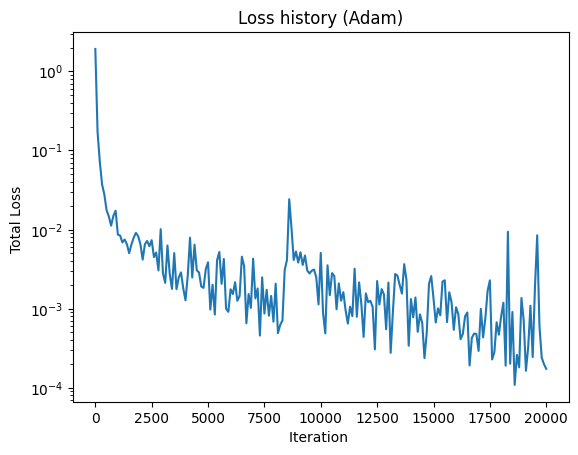

In [12]:
losshistory, train_state = model.train(epochs = 200000)
dde.saveplot(losshistory, train_state, issave = False, isplot = False)
loss_train = losshistory.loss_train
loss_sum = np.array([np.sum(loss) for loss in loss_train])
plt.plot(np.arange(len(loss_sum)) * 1000, loss_sum)
plt.yscale('log')
plt.xlabel('Iteration ')
plt.ylabel('Total Loss ')
plt.title('Loss history (Adam)')
plt.show()

### L-bfgs

Compiling model...
'compile' took 1.066954 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
200000    [5.67e-05, 8.88e-06, 3.29e-05, 9.63e-06, 4.75e-06, 2.11e-05, 1.14e-05, 1.16e-05, 4.06e-06, 9.38e-06, 2.31e-07, 2.62e-06]    [5.67e-05, 8.88e-06, 3.29e-05, 9.63e-06, 4.75e-06, 2.11e-05, 1.14e-05, 1.16e-05, 4.06e-06, 9.38e-06, 2.31e-07, 2.62e-06]    []  
201000    [8.21e-06, 5.69e-06, 7.40e-06, 5.66e-06, 2.05e-06, 1.19e-05, 3.03e-06, 2.00e-06, 3.23e-06, 2.76e-06, 1.14e-07, 2.65e-06]    [8.21e-06, 5.69e-06, 7.40e-06, 5.66e-06, 2.05e-06, 1.19e-05, 3.03e-06, 2.00e-06, 3.23e-06, 2.76e-06, 1.14e-07, 2.65e-06]        
202000    [7.27e-06, 4.94e-06, 6.10e-06, 5.30e-06, 1.65e-06, 7.82e-06, 2.78e-06, 1.27e-06, 2.22e-06, 1.93e-06, 9.38e-08, 2.68e-06]    [7.27

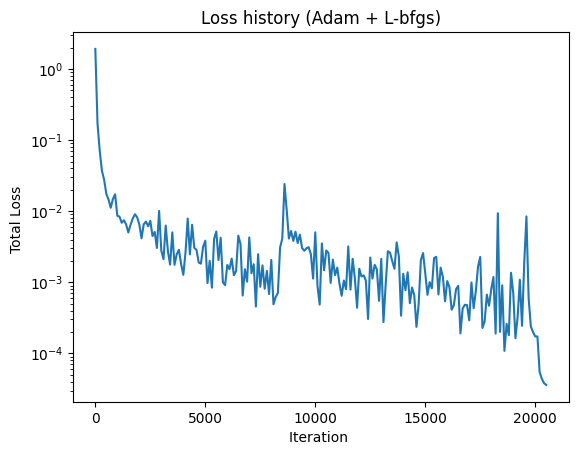

In [13]:
dde.optimizers.config.set_LBFGS_options(maxiter = 300000)

model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False, isplot = False)
loss_train = losshistory.loss_train
loss_sum = np.array([np.sum(loss) for loss in loss_train])
plt.plot(np.arange(len(loss_sum)) * 1000, loss_sum)
plt.yscale('log')
plt.xlabel('Iteration ')
plt.ylabel('Total Loss ')
plt.title('Loss history (Adam + L-bfgs)')
plt.show()

### Afficher des figures

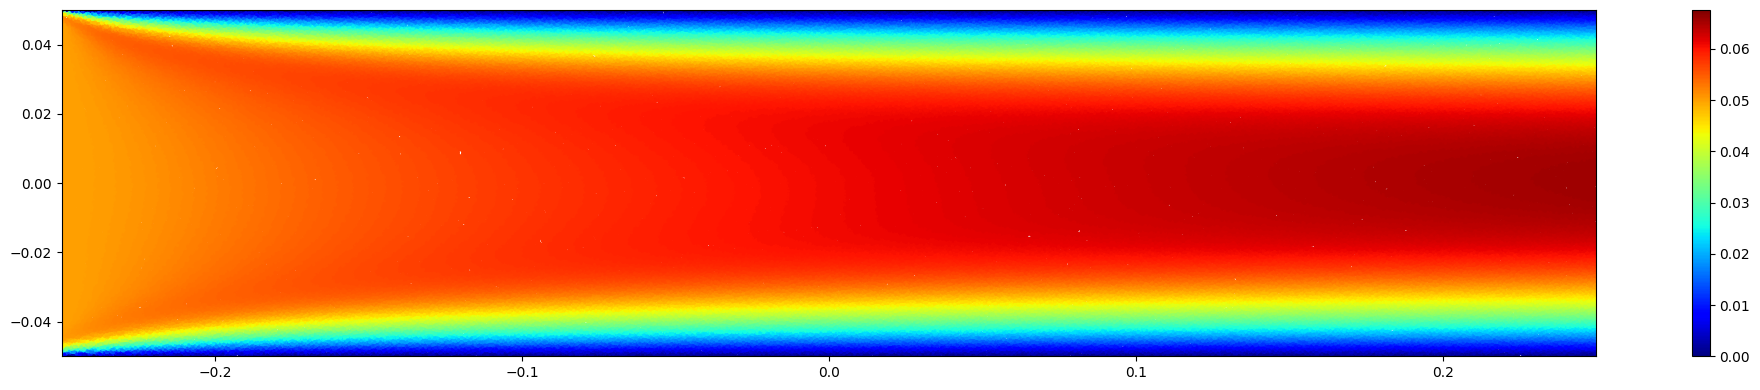

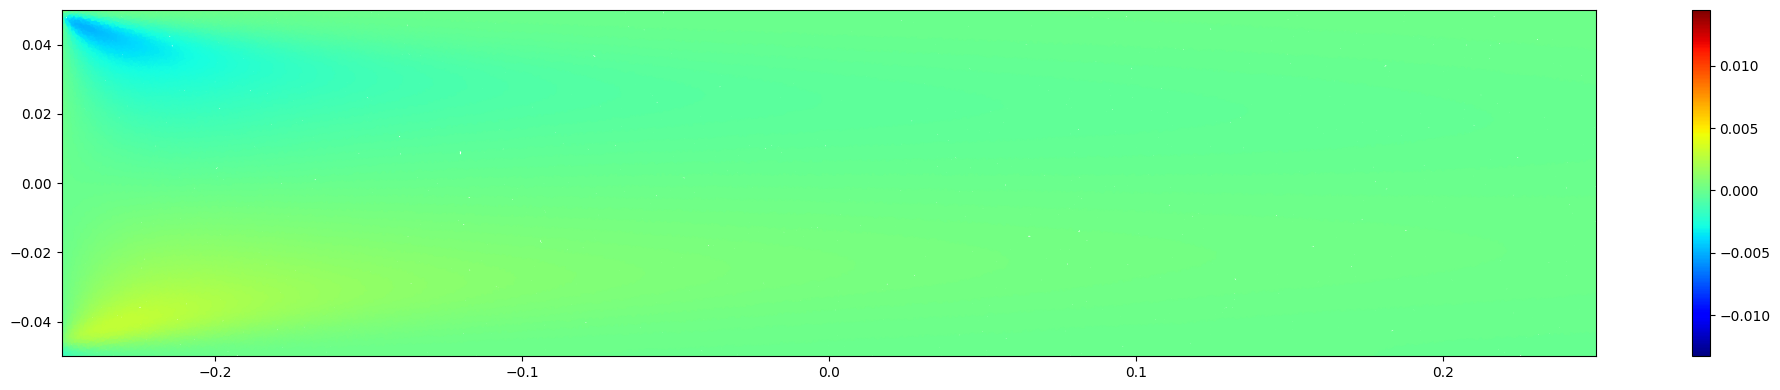

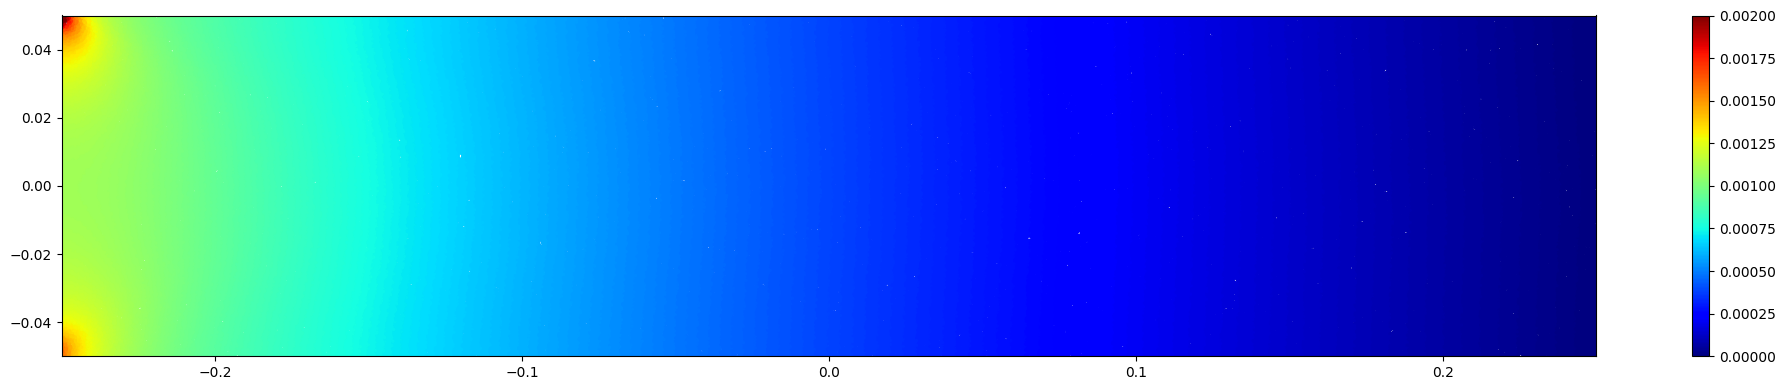

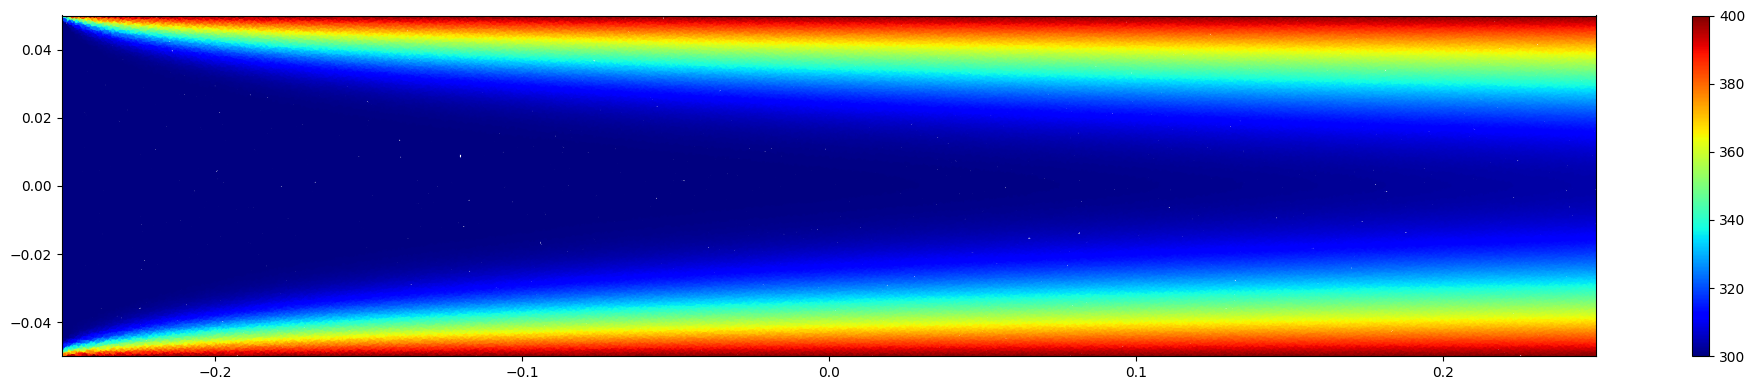

In [16]:
samples = np.random.rand(500000, 2)
samples[:, 0] = (samples[:, 0] - 0.5) * L
samples[:, 1] = (samples[:, 1] - 0.5) * D
result = model.predict(samples)
result[:,0]= result[:,0]*u1
result[:,1]= result[:,1]*u1
result[:,2]= result[:,2]*rho1*u1**2
result[:,3]= result[:,3]*(T1-T0)+T0
samples[:, 0]=samples[:, 0]*0.2
samples[:, 1]=samples[:, 1]*0.2

color_legend = [[0, 0.0676], [-0.01331, 0.01447], [0, 0.002],[300,400]]
for idx in range(4):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2*0.2, L*0.2-L/2*0.2))
    plt.ylim((0-D/2*0.2, D*0.2-D/2*0.2))
    plt.tight_layout()
    plt.show()